In [1]:
from ibmm import EyeClassifier
# from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

from parser_utils import read_periph_recording, parse_new_dreyevr_rec
from pathlib import Path
from tqdm import tqdm
import pickle as pkl

In [2]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [3]:

path_to_recording = "C://carla//carla.periph//RecordingTxts//tab/tab55.txt"
path_to_recording = "C://carla//carla.periph//RecordingTxts//george//george-55.txt"

recording_name = Path(path_to_recording).stem
recdf_pklname = Path("temp_data").joinpath(recording_name+".pkl")

# try:
#     df1 = pd.read_pickle(recdf_pklname)
# except FileNotFoundError:
#     df1 = read_periph_recording(path_to_recording)
#     df1.to_pickle(recdf_pklname)
# df1 = df1.convert_dtypes()

In [4]:
df = parse_new_dreyevr_rec(path_to_recording, False)
df1 = df.copy()

100%|██████████████████████████████████████████████████████████████████████████| 4595/4595 [00:11<00:00, 400.30it/s]


## Data Playground and Sanity checks

In [5]:
# find the indices where lights came on and went off
lighton_rows = df1["LightOn"].diff().fillna(0)==1
lightoff_rows = df1["LightOn"].diff().fillna(0)==-1
df1[lighton_rows].head()
lighton_idcs = df1[lighton_rows].index
num_targets_spawned = sum(lighton_rows)
# find the indices where the button was pressed
buttonPress_rows = df1["ButtonPressed"].diff().fillna(0)==1
buttonRelease_rows = df1["ButtonPressed"].diff().fillna(0)==-1
num_button_presses = sum(buttonPress_rows)
print("{} targets spawned".format(num_targets_spawned))
print("{} responses recorded".format(num_button_presses)) # may or may not be all accurate responses that correspond to targets?

13 targets spawned
1 responses recorded


In [6]:
df2 = df1.copy()
df2['gaze_x'] = df1.GazeDir_COMBINED.apply(lambda x: x[0])
df2['gaze_y'] = df1.GazeDir_COMBINED.apply(lambda x: x[1])
df2['gaze_z'] = df1.GazeDir_COMBINED.apply(lambda x: x[2])

gaze_pitches = np.arctan2(df2.gaze_z, df2.gaze_x)*180/np.pi
gaze_yaws = np.arctan2(df2.gaze_y, df2.gaze_x)*180/np.pi

low_conf_gazeidcs = (gaze_pitches*gaze_yaws == 0)
gaze_pitches = gaze_pitches[~low_conf_gazeidcs]
gaze_yaws = gaze_yaws[~low_conf_gazeidcs]


print(np.min(gaze_pitches),np.max(gaze_pitches))
print(np.min(gaze_yaws),np.max(gaze_yaws))

-20.454155973970373 6.615127535355882
-23.63269884006146 31.37779315493149


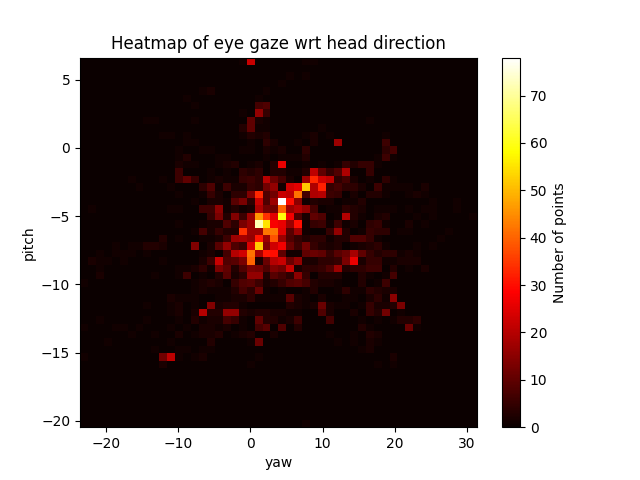

In [7]:
#gaze_pitches = gaze_pitches[1000:7000]
#gaze_yaws = gaze_yaws[6000:7000]

# Generate heat map of eye gaze wrt head pos
plt.figure()
plt.hist2d(gaze_yaws, gaze_pitches,
           bins=50, cmap='hot')
cb = plt.colorbar()
cb.set_label('Number of points')
plt.title('Heatmap of eye gaze wrt head direction')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.xlabel('yaw')
plt.ylabel('pitch')
plt.show()

## Hits and Misses calculation

In [8]:
# for every light appearance
# find the nearest button press, before the next target appearance
max_reaction_time_allowed = 5 #seconds
time_offsets = []
hits_and_misses = []
for idx_num, lighton_idx in tqdm(enumerate(lighton_idcs)):
    # while not found_buttonpress or lighton_idcs[idx_num+1]:
    offset = 0
    target_tuple = (df1.loc[lighton_idx], False)
    while lighton_idx+offset < max(df1.index):
        time_offset = df1.loc[lighton_idx+offset, "TimeElapsed"] - df1.loc[lighton_idx, "TimeElapsed"]   
        if (df1.loc[lighton_idx+offset, "ButtonPressed"] == 1):
            # print("{0:1.2f}s".format(time_offset))
            time_offsets += [time_offset]
            target_tuple = (df1.loc[lighton_idx], df1.loc[lighton_idx+offset])
            break
        else:
            if time_offset > max_reaction_time_allowed:
                break
            offset += 1
    hits_and_misses += [target_tuple]
    
print("{}/{} hits with a {}s average reaction time".format(len(time_offsets), len(lighton_idcs), sum(time_offsets)/len(time_offsets)))

13it [00:00, 178.56it/s]

12/13 hits with a 0.041549999999999976s average reaction time


## Prelim analysis

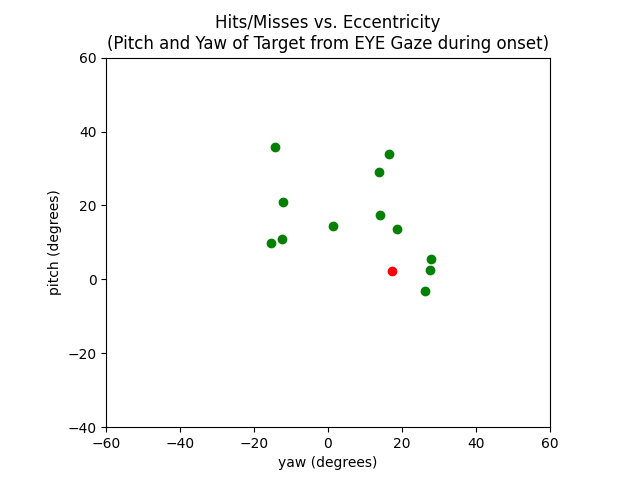

In [9]:
# Preliminary analysis
fig, ax = plt.subplots()

# plots of hits misses vs ecc
for target_tuple in hits_and_misses:
    target_response = True
    if target_tuple[1] is False:
        # miss
        target_response = False
        pass
    else:
        # hits
        pass
        # print(target_tuple[1].ButtonPressed)
    ax.scatter(target_tuple[0].gaze2target_yaw*180/np.pi,
               target_tuple[0].gaze2target_pitch*180/np.pi,
               c='g' if target_response else 'r')
    ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from EYE Gaze during onset)")
    
    # ax.scatter(target_tuple[0].head2target_yaw*180/np.pi, target_tuple[0].head2target_pitch*180/np.pi, c='g' if target_response else 'r')
    # ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from HEAD Gaze during onset)")
    
    ax.set_xlabel("yaw (degrees)")
    ax.set_ylabel("pitch (degrees)")
    ax.set_xlim(-60, 60)
    ax.set_ylim(-40, 60)
    ax.set_aspect('equal')
    # ax.show()

## Gaze event detection (eye gaze vector only)


In [10]:
from ibmm import EyeClassifier
from ibmm_online import EyeClassifierOnline

In [11]:
df2 = df1.copy()
df2['Lgaze_x'] = df1.GazeDir_LEFT.apply(lambda x: x[0])
df2['Lgaze_y'] = df1.GazeDir_LEFT.apply(lambda x: x[1])
df2['Lgaze_z'] = df1.GazeDir_LEFT.apply(lambda x: x[2])

df2['Rgaze_x'] = df1.GazeDir_RIGHT.apply(lambda x: x[0])
df2['Rgaze_y'] = df1.GazeDir_RIGHT.apply(lambda x: x[1])
df2['Rgaze_z'] = df1.GazeDir_RIGHT.apply(lambda x: x[2])

LgazeRaySplitDF = pd.DataFrame(df2[['Lgaze_x', 'Lgaze_y', 'Lgaze_z']])
LgazeRaySplitDF.rename(columns={'Lgaze_x': 'x', 'Lgaze_y': 'y', 'Lgaze_z': 'z'}, inplace=True)
LgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
LgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_LEFT"].astype(bool) # remove all gazes where an eye was closed

RgazeRaySplitDF = pd.DataFrame(df2[['Rgaze_x', 'Rgaze_y', 'Rgaze_z']])
RgazeRaySplitDF.rename(columns={'Rgaze_x': 'x', 'Rgaze_y': 'y', 'Rgaze_z': 'z'}, inplace=True)
RgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
RgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_RIGHT"].astype(bool) # remove all gazes where an eye was closed

In [12]:
velL = EyeClassifier.preprocess(LgazeRaySplitDF, dist_method='vector')
velL.velocity = velL.velocity.astype(float)
velR = EyeClassifier.preprocess(RgazeRaySplitDF, dist_method='vector')
velR.velocity = velR.velocity.astype(float)

In [13]:
model = EyeClassifier()
model.fit(eyes=(velL, velR))

In [14]:
labels, indiv_labels = model.predict(eyes=(velL, velR))
# print(labels)
# 0- fix, 1- sac, -1 -> noise
labels_unique = labels[1::2]
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
recdf_with_labels = df2.join(labels_unique["label"])

labels_np.shape:  (4595, 5)


In [15]:
print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))
print("Num LightOns: ", num_targets_spawned)

Num fixation total pts:  4272
Num saccades total pts:  188
Num noise total pts:  135

Num fixations:  168
Num saccades:  161
Num noise:  32
Num LightOns:  13


## OFD analysis

In [18]:
recording_name

'george-55'

In [ ]:
# need a data format that stores:
# all the data from hits and misses
# what trial/recording file it corresponds to: recording_name -- this is also stored in the pkl name
# 

12/13 valid targets
12 fixation onsets, 0 sacc, 0 noise


Text(0.5, 1.0, 'Hits/Misses on Gaze Eccentricity vs. OFD')

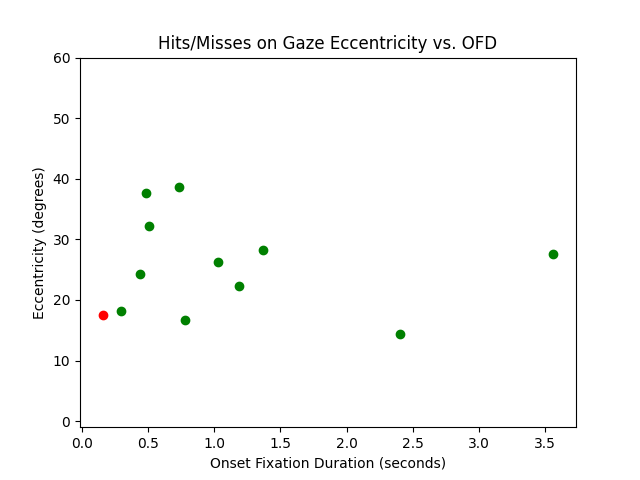

In [16]:
# target tuples, go back and find labels
saccade_onsets = 0
fixation_onsets = 0
noise_onsets = 0
fig, ax = plt.subplots()
graph_tuples = []

for target_tuple in hits_and_misses:
    # for either hit or miss, go back and find the ofd
    # check if you're in a fixation rn
    if target_tuple[0].GazeValid_COMBINED==0: # check gaze validity 
        continue
    target_locindf = target_tuple[0].name
    onset_gaze_event = recdf_with_labels.loc[target_locindf].label  
    OFD = 0
    pitch = recdf_with_labels.loc[target_locindf].gaze2target_pitch
           # + recdf_with_labels.loc[target_locindf].head2target_pitch
    yaw = recdf_with_labels.loc[target_locindf].gaze2target_yaw 
           # + recdf_with_labels.loc[target_locindf].head2target_yaw
    
    if onset_gaze_event == 0:
        fixation_onsets += 1
        # go back and look at when this current fixation ends
        # labels going back from current gaze
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        np.diff(labels_upto_curr)
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        label_diff = np.diff(labels_upto_curr)!=0
        first_fixation_idx = target_locindf - np.argmax(label_diff)
        OFD = recdf_with_labels.loc[target_locindf].TimeElapsed -\
                recdf_with_labels.loc[first_fixation_idx].TimeElapsed
        
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OFD, eccentricity, target_tuple[1] is False, pitch, yaw)
    elif onset_gaze_event == 1:
        saccade_onsets += 1
        OFD = 0        
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OFD, eccentricity, target_tuple[1] is False, pitch, yaw)
    else:
        noise_onsets += 1
    # print(target_locindf, OFD)
print("{}/{} valid targets".format(
        fixation_onsets+saccade_onsets+noise_onsets,
        len(hits_and_misses)))
print("{} fixation onsets, {} sacc, {} noise".format(fixation_onsets, saccade_onsets, noise_onsets))

#plt.xlim(0, )
ax.set_ylim(-1, 60)
ax.set_xlabel("Onset Fixation Duration (seconds)")
ax.set_ylabel("Eccentricity (degrees)")
ax.set_title("Hits/Misses on Gaze Eccentricity vs. OFD")

In [17]:
# temp hack for henny meeting: save graph tuples
graph_data_filname = Path("temp_data").joinpath(recording_name+"_OFDvEcc.pkl")
with open(graph_data_filname, 'wb') as f:
    pkl.dump(graph_tuples, f)